# Import Dependencies

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.model_selection import train_test_split

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, Conv1D, MaxPooling1D, Dense, Dropout, LSTM
from keras.models import Sequential
from keras.metrics import Precision, Recall
from keras.callbacks import EarlyStopping
from keras import backend


# Mount Google Drive To Load Dataset And Save Best Model

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load Balanced Dataset

In [3]:
balanced_data = pd.read_csv('/content/drive/MyDrive/NLP/Project/Dataset/HateSpeechDatasetBalanced.csv')

# Show Basic Dataset Info

In [4]:
balanced_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 726119 entries, 0 to 726118
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   Content  726119 non-null  object
 1   Label    726119 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 11.1+ MB


In [5]:
# 0 means not hateful
# 1 means hateful
balanced_data['Label'].value_counts()

Label
1    364525
0    361594
Name: count, dtype: int64

# Split Data Into Training & Validation Sets With An 80/20 Split

In [6]:
# split the dataframe into features (X) and labels (y)
X = balanced_data['Content']
y = balanced_data['Label']

# split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Tokenize the Data

In [7]:
# use only the to 10000 unique words
max_words = 10000

# tokenize the text data
tokenizer = Tokenizer(num_words=max_words, lower=True)
tokenizer.fit_on_texts(X_train)

# print the number of unique tokens in the dataset
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 127640 unique tokens.


In [8]:
max_len = 50

# convert X_train and X_val to list of indicies from the tokenizer
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_val=tokenizer.texts_to_sequences(X_val)
X_train = pad_sequences(sequences_train,maxlen=max_len)
X_val = pad_sequences(sequences_val,maxlen=max_len)

# Load GloVe Embeddings

In [9]:
word_vectors = dict()

# load pre-trained GloVe embeddings
f = open('/content/drive/MyDrive/NLP/Project/GloVe Embeddings/glove.twitter.27B.200d.txt', encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    word_vectors[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(word_vectors))


Loaded 1193514 word vectors.


In [10]:
num_tokens = len(word_index) + 1
embedding_dim = 200
hits = 0
misses = 0

# prepare embedding matrix with all zoroes
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = word_vectors.get(word)
    if embedding_vector is not None:
        # out of vocabulary words will be all-zeros
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 69082 words (58558 misses)


# Create Embeddings Layer

In [11]:
# create the embeddings layer
embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    trainable=False,
    name="GloVe"
)
embedding_layer.build((1,))
embedding_layer.set_weights([embedding_matrix])

# Build The CNN

In [12]:
# custom metric callback to pass to model.compile
def f1_metric(y_true, y_pred):
    y_true = tf.cast(y_true, "int32")
    y_pred = tf.cast(tf.round(y_pred), "int32")  # round predictions to closest integer (0 or 1)
    tp = tf.reduce_sum(tf.cast(tf.math.logical_and(tf.equal(y_true, 1), tf.equal(y_pred, 1)), "float32"), axis=0)
    fp = tf.reduce_sum(tf.cast(tf.math.logical_and(tf.equal(y_true, 0), tf.equal(y_pred, 1)), "float32"), axis=0)
    fn = tf.reduce_sum(tf.cast(tf.math.logical_and(tf.equal(y_true, 1), tf.equal(y_pred, 0)), "float32"), axis=0)

    precision = tp / (tp + fp + backend.epsilon())
    recall = tp / (tp + fn + backend.epsilon())

    f1 = 2 * precision * recall / (precision + recall + backend.epsilon())
    f1_score = tf.reduce_mean(f1)

    return f1_score

In [13]:
# create the GloVe enhanced CNN
model = Sequential()
model.add(embedding_layer)

model.add(Conv1D(64, 5, activation="relu"))
model.add(MaxPooling1D())
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dense(32, activation="relu"))
model.add(Dense(1, activation="sigmoid"))

model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall(), f1_metric])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 GloVe (Embedding)           (None, None, 200)         25528200  
                                                                 
 conv1d (Conv1D)             (None, None, 64)          64064     
                                                                 
 max_pooling1d (MaxPooling1  (None, None, 64)          0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, None, 64)          0         
                                                                 
 lstm (LSTM)                 (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                        

In [14]:
# get training data
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)

# get validation data
X_val = np.asarray(X_val)
y_val = np.asarray(y_val)

history = model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val), callbacks=EarlyStopping(monitor='val_loss', patience=2))


Epoch 1/10
18153/18153 [==============================] - 156s 8ms/step - loss: 0.4898 - accuracy: 0.7599 - precision: 0.7381 - recall: 0.8078 - f1_metric: 0.7637 - val_loss: 0.4299 - val_accuracy: 0.8022 - val_precision: 0.7901 - val_recall: 0.8273 - val_f1_metric: 0.8036
Epoch 2/10
18153/18153 [==============================] - 151s 8ms/step - loss: 0.4241 - accuracy: 0.8039 - precision: 0.7871 - recall: 0.8348 - f1_metric: 0.8049 - val_loss: 0.4078 - val_accuracy: 0.8139 - val_precision: 0.8216 - val_recall: 0.8055 - val_f1_metric: 0.8085
Epoch 3/10
18153/18153 [==============================] - 152s 8ms/step - loss: 0.4014 - accuracy: 0.8156 - precision: 0.7991 - recall: 0.8448 - f1_metric: 0.8163 - val_loss: 0.3835 - val_accuracy: 0.8252 - val_precision: 0.7987 - val_recall: 0.8731 - val_f1_metric: 0.8301
Epoch 4/10
18153/18153 [==============================] - 153s 8ms/step - loss: 0.3865 - accuracy: 0.8233 - precision: 0.8073 - recall: 0.8509 - f1_metric: 0.8237 - val_loss: 0.3

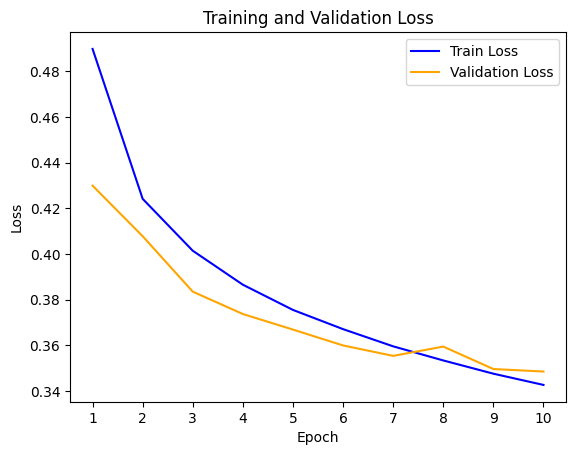

In [15]:
import matplotlib.pyplot as plt

# get training and validation loss from training history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

# plot training and validation loss
plt.plot(epochs, train_loss, color='blue', label='Train Loss')
plt.plot(epochs, val_loss, color='orange', label='Validation Loss')

# set plot and axis titles
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# set x ticks and add a legend
plt.xticks(range(1, len(train_loss) + 1))
plt.legend()

# show the plot
plt.show()


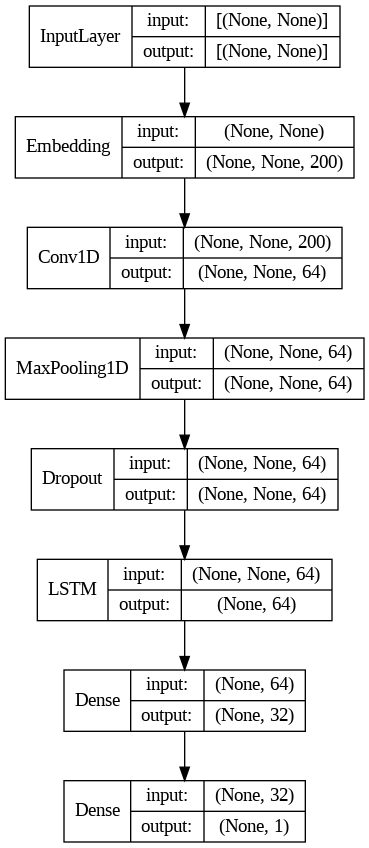

In [16]:
# plot the model architecture
tf.keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=False)